In [1]:
import numpy as np
from utilities import prepare_set
import matplotlib.pyplot as plt

from time import time

In [2]:
X_train, y_train, X_test, y_test, train_weights, test_weights = prepare_set('../data/D0_set_weighted.npy')

In [3]:
X_train.shape

(104768, 9)

In [4]:
X_test.shape

(11641, 9)

>S - ratio of # of classified signal (1) to # of counted signal in X_test  
B - ratio of # of classified background (0) to # of counted background in y_test

## ML model

In [5]:
learning_samples = 5000

def eff_signal(clf):
    '''How much of signal is classified as signal.'''
    test_count = 0
    fit_count = 0
    prediction = clf.predict(X_test[:learning_samples, 1:])
    for i in range(learning_samples):
        if y_test[i] == 1:
            test_count += 1
            if (y_test[i] == prediction[i]):
                fit_count += 1
    return fit_count / test_count * learning_samples

def eff_background(clf):
    '''How much of background is classified as background.'''
    test_count = 0
    fit_count = 0
    prediction = clf.predict(X_test[:learning_samples, 1:])
    for i in range(learning_samples):
        if y_test[i] == 0:
            test_count += 1
            if (y_test[i] == prediction[i]):
                fit_count += 1
    return (1 - fit_count / test_count) * learning_samples * 500
    
def high_score(clf):
    '''Function for scoring argument in model optimization'''
    S = eff_signal(clf)
    B = eff_background(clf)
    return S/np.sqrt(S+B)

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline 

### Decision Tree

In [7]:
from sklearn.tree import DecisionTreeClassifier

max_depth = [None, 10, 50, 100]
class_weight = [None, 'balanced']

decision_tree_pipe = DecisionTreeClassifier()

tree_param_grid = [{'max_depth':max_depth,
                  'class_weight':class_weight}]

tree_gs = GridSearchCV(estimator=decision_tree_pipe, 
                       param_grid=tree_param_grid, scoring='accuracy', 
                       cv=10, n_jobs=-1)


In [9]:
start_time = time()

tree_gs = tree_gs.fit(X_train[:learning_samples, 1:], y_train[:learning_samples])

print(f'Decision tree training time {time() - start_time}.')
print(f'Wydajnosc {high_score(tree_gs)}')
print(f'Decision tree best params {tree_gs.best_params_}')

Decision tree training time 1.4281096458435059.
Wydajnosc 8.282686679890173
Decision tree best params {'class_weight': None, 'max_depth': 10}


### PCA

In [10]:
pca = PCA()

pca.fit(X_train[:learning_samples, 1:])

PCA()

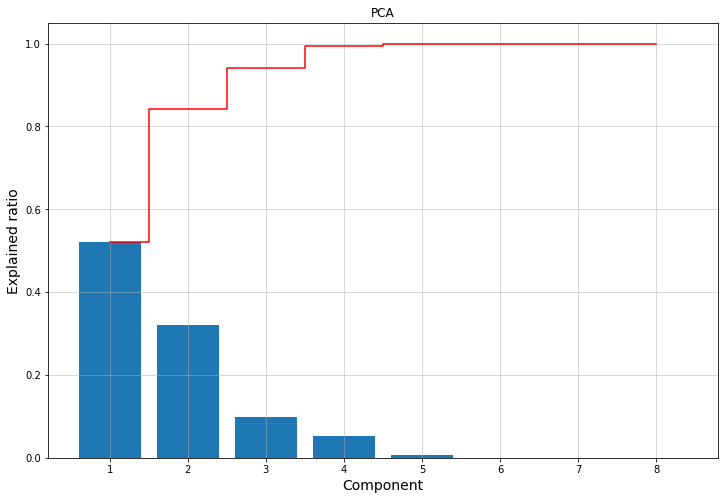

Components ratio: [5.20854153e-01 3.20488146e-01 9.86715381e-02 5.34550848e-02
 5.96239190e-03 2.92216020e-04 2.52577900e-04 2.38924848e-05]
Components ratio cumsum: [0.52085415 0.8413423  0.94001384 0.99346892 0.99943131 0.99972353
 0.99997611 1.        ]
3 komponenty objaśniają 94% zbioru!


In [12]:
plt.figure(figsize=(12,8))

plt.bar(range(1,9), pca.explained_variance_ratio_)
plt.step(range(1,9), np.cumsum(pca.explained_variance_ratio_), where='mid', color='red')

plt.title('PCA')

plt.xlabel('Component', fontsize=14)
plt.ylabel('Explained ratio', fontsize=14)

plt.grid(alpha=0.6)
plt.show()

print(f'Components ratio: {pca.explained_variance_ratio_}')
print(f'Components ratio cumsum: {np.cumsum(pca.explained_variance_ratio_)}')
print('3 komponenty objaśniają 94% zbioru!')

### SVC

In [13]:
from sklearn.svm import SVC

value_param = [0.01, 0.1, 1.0, 10, 100, 1000]

svc_pipe = make_pipeline(StandardScaler(), PCA(n_components=3), SVC())

svc_param_grid = [{'svc__C': value_param,
                  'svc__gamma': value_param,
                  'svc__class_weight': class_weight}]

svc_gs = GridSearchCV(estimator=svc_pipe, 
                       param_grid=svc_param_grid, scoring='accuracy', 
                       cv=10, n_jobs=-1)

In [14]:
start_time = time()

svc_gs = svc_gs.fit(X_train[:learning_samples, 1:], y_train[:learning_samples])

print(f'Support Vector Machine training time {time() - start_time}.')
print(f'Wydajnosc {high_score(svc_gs)}')
print(f'Decision tree best params {svc_gs.best_params_}')

KeyboardInterrupt: 

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

lr_pipe = make_pipeline(StandardScaler(), PCA(n_components=3), LogisticRegression(max_iter=200, n_jobs=-1))

lr_param_grid = [{'logisticregression__C': value_param,
                 'logisticregression__class_weight': class_weight,
                 'logisticregression__solver': ['saga', 'lbfgs']}]

lr_gs = GridSearchCV(estimator=lr_pipe, param_grid=lr_param_grid, scoring='accuracy',
                    cv=10, n_jobs=-1)

In [ ]:
start_time = time()

lr_gs = lr_gs.fit(X_train[:learning_samples, 1:], y_train[:learning_samples])

print(f'Logisti Regression training time {time() - start_time}.')
print(f'Wydajnosc {high_score(lr_gs)}')
print(f'Logistic Regression best params {lr_gs.best_params_}')

### Simple NN

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

## Przygotowanie zestawu danych

In [ ]:
y_train.mean()